## Experiment: cell type specificity of regression models

This experiment studies whether cluster-specific ridge regression is superior to regression shared across all training data. 

In [1]:
EXPERIMENT_NAME="clusterSpecific_v1"

In [2]:
import warnings
warnings.filterwarnings('ignore')
import importlib
import os
import sys
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co

#      visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

In [3]:
# Deal with various file paths specific to this project
PROJECT_PATH = '/home/ekernf01/Desktop/jhu/research/projects/perturbation_prediction/cell_type_knowledge_transfer/'
os.chdir(PROJECT_PATH + "benchmarking/")
try:
    os.makedirs("results/" + EXPERIMENT_NAME)
except:
    pass

sys.path.append(os.path.expanduser(PROJECT_PATH + 'networks/load_networks'))
sys.path.append(os.path.expanduser(PROJECT_PATH + 'perturbations/load_perturbations')) 
sys.path.append(os.path.expanduser(PROJECT_PATH + 'benchmarking/evaluator')) 
import evaluator
import load_networks
import load_perturbations
importlib.reload(evaluator) 
importlib.reload(load_networks) 
importlib.reload(load_perturbations)
os.environ["GRN_PATH"]           = PROJECT_PATH + "networks/networks"
os.environ["PERTURBATION_PATH"]  = PROJECT_PATH + "perturbations/perturbations"
print("Example networks:")
load_networks.load_grn_metadata().head(2)

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2
Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2
Example networks:


,name,description,data_used,species,link,citation,is_ready,first_column
name,,,,,,,,
cellnet_human_Hg1332,cellnet_human_Hg1332,CLR analysis of microarray data pulled off GEO,microarrays (HG133 plus 2 and HuGene 1.0),human,http://pcahan1.github.io/cellnetr/,"Cahan, P., Li, H., Morris, S. A., Da Rocha, E....",yes,symmetric
cellnet_human_Hugene,cellnet_human_Hugene,CLR analysis of microarray data pulled off GEO,microarrays (HG133 plus 2 and HuGene 1.0),human,http://pcahan1.github.io/cellnetr/,"Cahan, P., Li, H., Morris, S. A., Da Rocha, E....",yes,symmetric


### Networks setup

This experiment uses the two default networks: the dense network and the CO default network. 

In [4]:
networks = {
    'dense': evaluator.makeRandomNetwork(density = 1),
    'cellOracle': co.data.load_human_promoter_base_GRN()
}
network_sizes = pd.DataFrame({bn:evaluator.countMatrixEdges(networks[bn]) for bn in networks}, index = ["numEdges"])
network_sizes = network_sizes.T.reset_index().rename({"index":"network"}, axis = 1)
network_sizes

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


,network,numEdges
0,dense,102313295.0
1,cellOracle,5134330.0


### Data setup

We use the Nakatake et al data. This experiment is on per-cluster versus shared regression models, so we run Leiden clustering at many different resolutions.

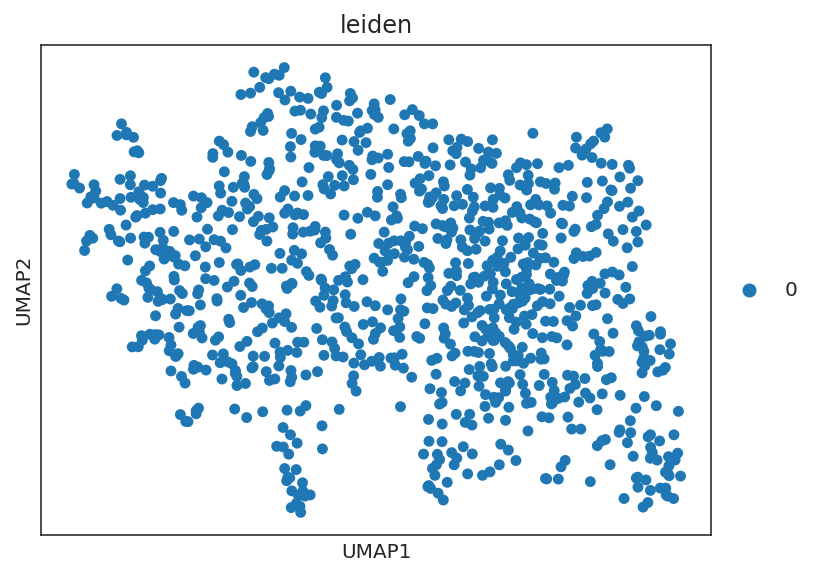

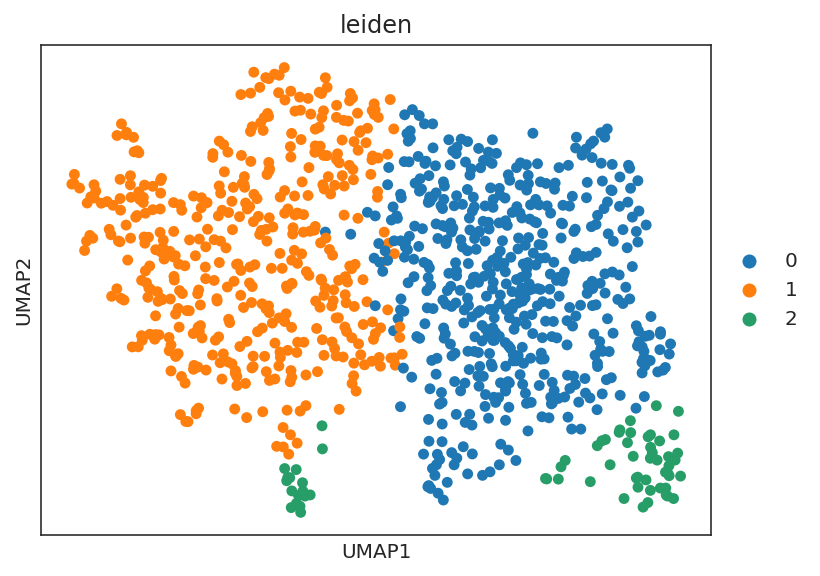

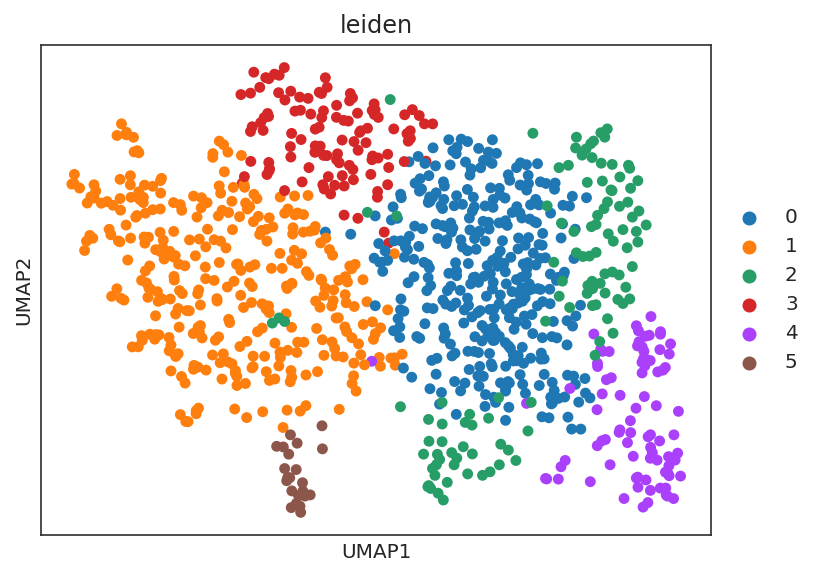

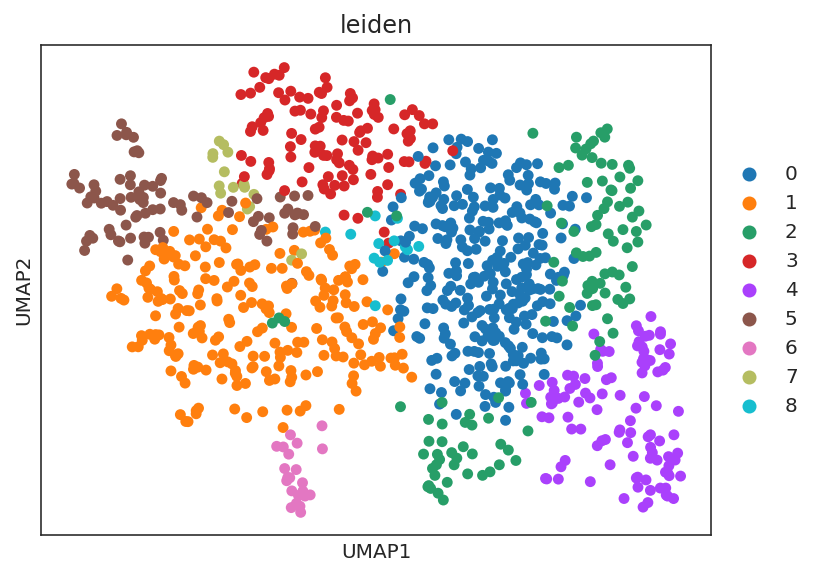

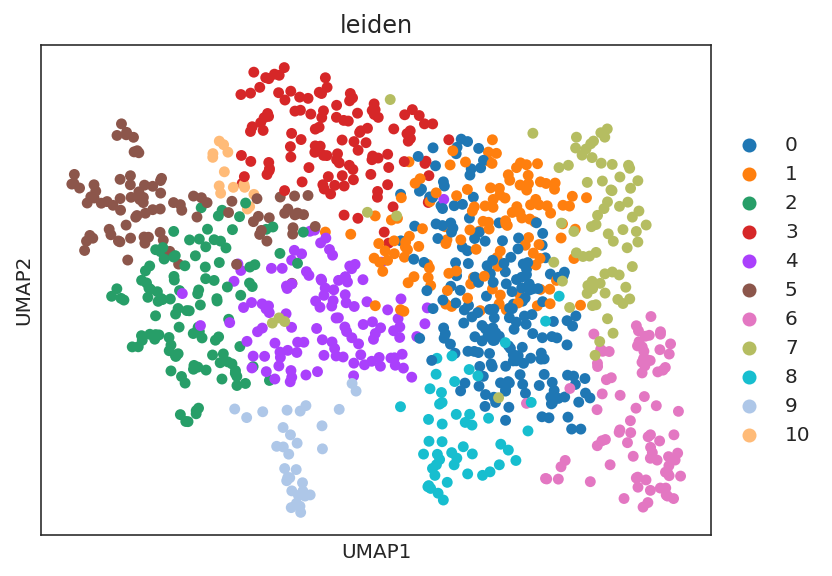

In [5]:
ko_lab_esc_data = sc.read_h5ad(os.environ["PERTURBATION_PATH"] + "/nakatake/" + "test.h5ad")
clusterResolutions = []
for r in [i/10.0 for i in range(1,11,2)]:
    sc.tl.leiden(ko_lab_esc_data, resolution=r)
    new_name = "leiden_r="+str(round(r, 1))
    clusterResolutions.append(new_name)
    ko_lab_esc_data.obs[new_name] = ko_lab_esc_data.obs["leiden"]
    sc.pl.umap(ko_lab_esc_data, color = "leiden")
    ko_lab_esc_data.obs[new_name] = ko_lab_esc_data.obs[new_name].astype("category")
    ko_lab_esc_data.uns[new_name + "_colors"] = ko_lab_esc_data.uns["leiden_colors"]

### Training and test split

A few factors complicate the training-test split. 

- Perturbed genes may be absent from most base GRN's due to lack of motif information or ChIP data. These are excluded from the test data to avoid obvious failure cases.
- Perturbed genes may not be measured. These are excluded from test data because we don't know to what extent they were overexpressed.

In both cases, we still use those perturbed profiles as training data, hoping they will provide useful info about attainable cell states and downstream causal effects. 

For some collections of base networks, there are many factors ineligible for use as test data -- so many that we use all the eligible ones for test and the only ineligible ones for training. 

For other cases, such as dense base networks, that would leave too small a training set, so we send some perturbations to the training set at random even if we would be able to use them in the test set. We ensure there are at least 250 training examples. 

In [6]:
test_set_regulators = set.intersection(*[set(networks[key].columns) 
                                      for key in networks if not key == 'empty'])
test_set_regulators = test_set_regulators.difference(ko_lab_esc_data.uns["perturbed_but_not_measured_genes"])
testSetPerturbations     = set(ko_lab_esc_data.obs['perturbation']).intersection(test_set_regulators)
trainingSetPerturbations = set(ko_lab_esc_data.obs['perturbation']).difference(test_set_regulators)
if len(trainingSetPerturbations) < 250:
    swap = np.random.default_rng(seed=0).choice(list(testSetPerturbations), 
                                           250 - len(trainingSetPerturbations), 
                                           replace = False)
    testSetPerturbations = testSetPerturbations.difference(swap)
    trainingSetPerturbations = trainingSetPerturbations.union(swap)
ko_lab_esc_data_heldout  = ko_lab_esc_data[ko_lab_esc_data.obs["perturbation"].isin(testSetPerturbations),    :]
ko_lab_esc_data_train    = ko_lab_esc_data[ko_lab_esc_data.obs["perturbation"].isin(trainingSetPerturbations),:]
ko_lab_esc_data_train.obs['perturbation'].unique()
perturbationsToPredict = [(gene, ko_lab_esc_data_heldout[sample, gene].X[0,0]) for sample,gene in enumerate(ko_lab_esc_data_heldout.obs['perturbation'])] 
print("Example perturbations formatted as \n (gene, expression after perturbation)")
print(perturbationsToPredict[0:5])
print("Test set size:")
print(len(testSetPerturbations))
print("Training set size:")
print(len(trainingSetPerturbations))

Example perturbations formatted as 
 (gene, expression after perturbation)
[('ALX3', 2.829177), ('ALX3', 3.583377), ('ALX4', 1.1726332), ('ALX4', 0.7964212), ('AR', 1.1614258)]
Test set size:
263
Training set size:
250


### Experimental metadata

In [7]:
n_networks = len(networks.keys())
n_resolutions = len(clusterResolutions)
experiments = pd.DataFrame({"network":[n for n in networks.keys()]*n_resolutions, 
                            "cluster_resolution":clusterResolutions + clusterResolutions,
                            "p":[1]*n_networks*n_resolutions,
                            "threshold_number":[int(network_sizes['numEdges'].max())]*n_networks*n_resolutions,
                            "pruning":["none"]*n_networks*n_resolutions})
experiments["index"] = experiments.index
experiments.to_csv("results/" + EXPERIMENT_NAME + "/networkExperiments.csv")
experiments

,network,cluster_resolution,p,threshold_number,pruning,index
0,dense,leiden_r=0.1,1,102313295,none,0
1,cellOracle,leiden_r=0.3,1,102313295,none,1
2,dense,leiden_r=0.5,1,102313295,none,2
3,cellOracle,leiden_r=0.7,1,102313295,none,3
4,dense,leiden_r=0.9,1,102313295,none,4
5,cellOracle,leiden_r=0.1,1,102313295,none,5
6,dense,leiden_r=0.3,1,102313295,none,6
7,cellOracle,leiden_r=0.5,1,102313295,none,7
8,dense,leiden_r=0.7,1,102313295,none,8
9,cellOracle,leiden_r=0.9,1,102313295,none,9


Trying to set attribute `._uns` of view, copying.


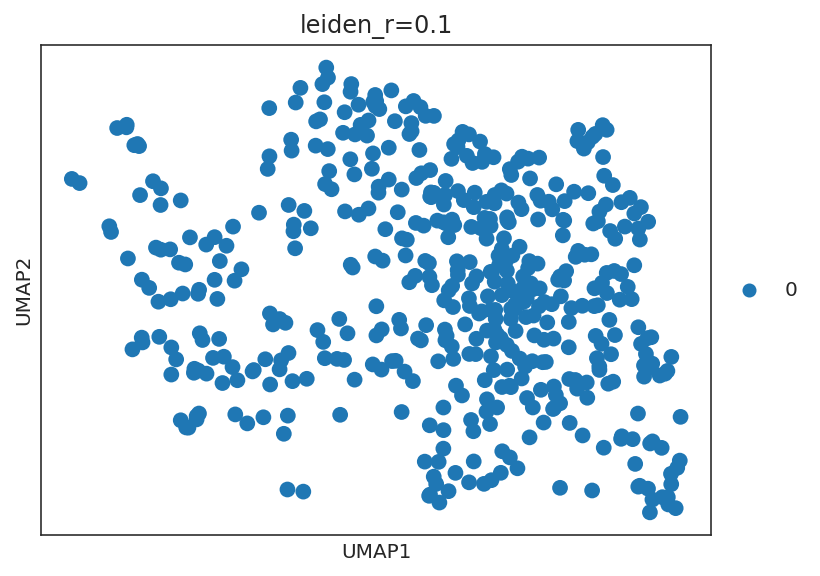

Working on results/clusterSpecific_v1/0.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/1 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/2407 [00:00<?, ?it/s]

fitting GRN again...
calculating GRN in 0


  0%|          | 0/2603 [00:00<?, ?it/s]

genes_in_gem: 2603
models made for 2407 genes
Predicting ZNF384
ALX3 ALX3 ALX4 ALX4 AR AR ARID3A ARID3A ARNT2 ARNT2 ASCL1 ASCL1 BACH1 BACH1 BARHL2 BARHL2 BATF BATF BCL6 BCL6 BHLHE40 BHLHE40 BRF2 BRF2 CDX2 CDX2 CDX2 CEBPA CEBPA CEBPD CEBPD CREB1 CREB1 CREB3 CREB3 CTCF CTCFL CTCFL DLX2 DLX2 DMRT1 DMRT1 DMRTC2 DMRTC2 E2F4 E2F4 E2F6 E2F6 E2F7 E2F7 EGR1 EGR1 EGR2 EGR2 EHF EHF ELF1 ELF1 ELF2 ELF2 ELF4 ELF5 ELF5 ELK1 ELK1 ELK3 ELK3 EOMES EOMES ERG ERG ESRRA ESRRA ESRRB ESRRB ESRRG ESRRG ESX1 ESX1 ETS1 ETS1 ETS2 ETS2 ETV1 ETV1 ETV2 ETV2 ETV3 ETV3 ETV5 ETV5 ETV6 ETV6 FLI1 FLI1 FOS FOS FOSL1 FOSL1 FOSL2 FOSL2 FOXA1 FOXA1 FOXA2 FOXA2 FOXB1 FOXB1 FOXC1 FOXC1 FOXD3 FOXD3 FOXF1 FOXF1 FOXG1 FOXG1 FOXH1 FOXH1 FOXJ1 FOXJ1 FOXM1 FOXM1 FOXN3 FOXN3 FOXO3 FOXO3 FOXP3 FOXP3 FOXS1 FOXS1 GATA1 GATA1 GATA2 GATA2 GATA3 GATA3 GBX2 GBX2 GLI1 GLI1 GLIS2 GLIS2 GRHL2 GRHL2 GSC GSC GTF3C2 GTF3C2 HDAC2 HDAC2 HES1 HES1 HESX1 HESX1 HEY1 HEY1 HMGA2 HMGA2 HNF4A HNF4A HOXA2 HOXA2 HOXA9 HOXA9 HOXB4 HOXB4 HOXC9 HOXC9 HOXD10 

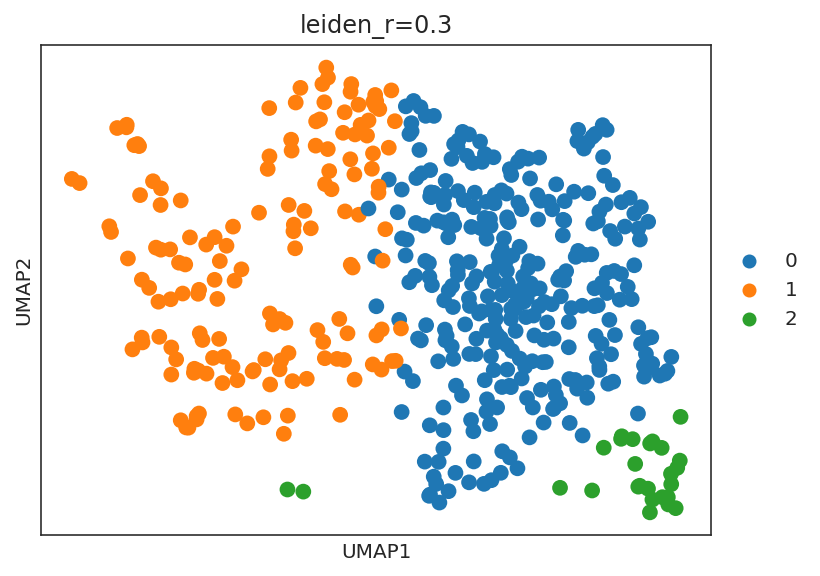

Working on results/clusterSpecific_v1/1.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/3 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/2407 [00:00<?, ?it/s]

inferring GRN for 1...


  0%|          | 0/2407 [00:00<?, ?it/s]

Training failed with error SVD did not converge


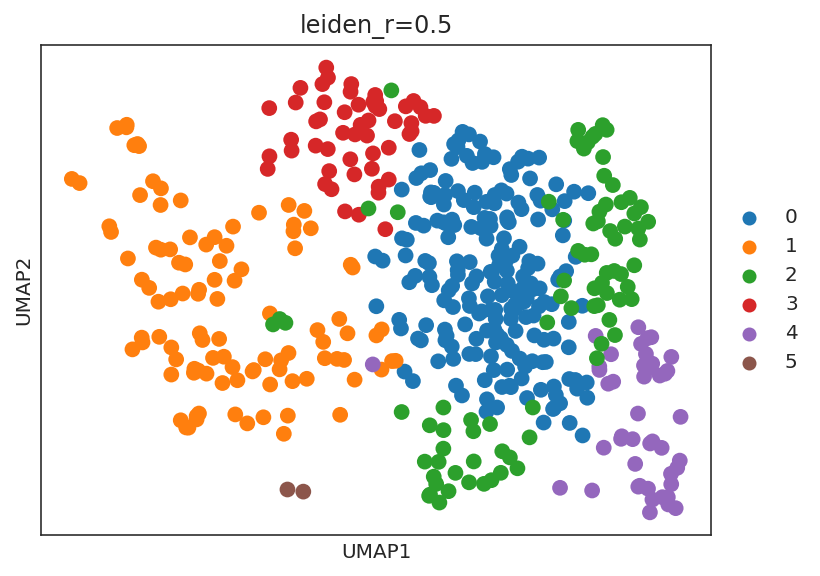

Working on results/clusterSpecific_v1/2.celloracle.oracle
Memoized results not found with error File not found. Please check if the file_path is correct.


  0%|          | 0/6 [00:00<?, ?it/s]

inferring GRN for 0...


  0%|          | 0/2407 [00:00<?, ?it/s]

inferring GRN for 1...


  0%|          | 0/2407 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
predictions = {
    i: evaluator.trainCausalModelAndPredict(expression=ko_lab_esc_data_train,
                                  baseNetwork=networks[experiments.loc[i,'network']],
                                  memoizationName="results/" + EXPERIMENT_NAME + "/" + str(i) + ".celloracle.oracle", 
                                  perturbations=perturbationsToPredict,
                                  clusterColumnName = experiments.loc[i, "cluster_resolution"],
                                  pruningParameters = {"p":experiments.loc[i,'p'], 
                                                       "threshold_number":experiments.loc[i,'threshold_number']}) 
    for i in experiments.index
}


In [ ]:
predictions[0]

### Evaluation

We compute the correlation of the predictions with held-out perturbations.

In [ ]:
controlIndex = ko_lab_esc_data_train.obs["perturbation"]=="Control"
evaluationResults = {}
for i in predictions:
    evaluationResults[i] = \
        evaluator.evaluateCausalModel(ko_lab_esc_data_heldout, 
                            predictions[i],   
                            baseline = ko_lab_esc_data_train[controlIndex,:].X.mean(axis=0),     
                            doPlots=False)[0]
    evaluationResults[i]["index"] = i
evaluationResults = pd.concat(evaluationResults)
evaluationResults = evaluationResults.merge(experiments, how = "left")
evaluationResults = pd.DataFrame(evaluationResults.to_dict())
evaluationResults.head()

In [ ]:
noPredictionMade = evaluationResults.iloc[[x==0 for x in evaluationResults["spearman"]],:]['perturbation']
noPredictionMade = set(noPredictionMade)
noPredictionMade
evaluationResults["somePredictionRefused"] = evaluationResults["perturbation"].isin(noPredictionMade) 
evaluationResults.to_csv("results/"+ EXPERIMENT_NAME +"/networksExperimentEvaluation.csv")
evaluationResults.head()

In [ ]:
evaluationResults[~evaluationResults['somePredictionRefused']]

In [ ]:
baseNetworkComparisonFigure = sns.FacetGrid(evaluationResults, 
                                            col = 'network',
                                            sharey = False, 
                                            height=5, 
                                            aspect=1).set(title = "Performance")
baseNetworkComparisonFigure.map(sns.violinplot, "spearman", "cluster_resolution").add_legend()
baseNetworkComparisonFigure.set(ylabel="Spearman correlation\nminus average over all methods")
plt.show()

In [ ]:
summary = evaluationResults[~evaluationResults['somePredictionRefused']]
summary = summary.groupby(["pruning", "network"]).mean()[["spearman"]].reset_index(["pruning", "network"])
summary = summary.merge(network_sizes)
summary.sort_values(['pruning', 'network'], inplace=True)
summary.to_csv("../results/" + EXPERIMENT_NAME + "/networksExperimentEvaluationSummary.csv")
print(summary)
baseNetworkComparisonFigureCompact = sns.scatterplot(data=summary[[p!="harsh" for p in summary["pruning"]]],
                x='numEdges',
                y='spearman', 
                hue='network')
baseNetworkComparisonFigureCompact.set_xscale("log")
baseNetworkComparisonFigureCompact.set(title="Density vs performance")
baseNetworkComparisonFigureCompact.legend(loc='center left', bbox_to_anchor=(1, 0.5))
